### Задание
- Обучить Bert для задачи оптимизации
- Датасет: IDMB

### Анализ
- Bert из библиотеки transformers
- Использование техник накопления градиента, регуляризации, warmup, weight_decay и планировщика скорости обучения

### Имплементация

Подключение библиотек, подготовка данных для модели

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_cosine_with_hard_restarts_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import torch.amp as amp

MAX_LEN = 256
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 5e-5
GRADIENT_ACCUMULATION_STEPS = 32
WARMUP_STEPS = 400
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = load_dataset('imdb')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        encoding = tokenizer.encode_plus(
            self.reviews[idx],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = IMDBDataset(dataset['train']['text'], dataset['train']['label'])
val_dataset = IMDBDataset(dataset['test']['text'], dataset['test']['label'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=10)

- Создание модели Bert
- Оптимизатор AdamW
- Использование техники накопления градиента
- Планировщик с плавным повышением скорости обучения в начале и изменяющийся по косиносному закону в конце

In [2]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.02)
total_steps = len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

scaler = amp.GradScaler(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Функции обучения и инференса

In [3]:
train_losses = []
val_losses = []
accuracies = []
f1_scores = []

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(dataloader)):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        with amp.autocast(str(DEVICE)):
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS
        
        scaler.scale(loss).backward()
        
        if (i + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    
    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Обучение модели

In [4]:
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    
    train_loss = train_epoch(model, train_loader)
    train_losses.append(train_loss)
    
    val_metrics = evaluate(model, val_loader)
    val_losses.append(val_metrics['loss'])
    accuracies.append(val_metrics['accuracy'])
    f1_scores.append(val_metrics['f1'])
    
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Train Loss: {train_loss:.4f}; Val Loss: {val_metrics["loss"]:.4f}; Accuracy: {val_metrics["accuracy"]:.4f}; F1 Score: {val_metrics["f1"]:.4f}; Precision: {val_metrics["precision"]:.4f}; Recall: {val_metrics["recall"]:.4f}\n')

Epoch 1/25


100%|██████████| 390/390 [02:50<00:00,  2.28it/s]


Train Loss: 0.7026; Val Loss: 0.6990; Accuracy: 0.4914; F1 Score: 0.1317; Precision: 0.4498; Recall: 0.0771

Epoch 2/25


100%|██████████| 390/390 [02:52<00:00,  2.26it/s]


Train Loss: 0.7009; Val Loss: 0.6959; Accuracy: 0.4914; F1 Score: 0.3246; Precision: 0.4829; Recall: 0.2445

Epoch 3/25


100%|██████████| 390/390 [02:52<00:00,  2.26it/s]


Train Loss: 0.6968; Val Loss: 0.6912; Accuracy: 0.5252; F1 Score: 0.5579; Precision: 0.5220; Recall: 0.5992

Epoch 4/25


100%|██████████| 390/390 [02:48<00:00,  2.32it/s]


Train Loss: 0.6904; Val Loss: 0.6837; Accuracy: 0.5747; F1 Score: 0.6493; Precision: 0.5524; Recall: 0.7873

Epoch 5/25


100%|██████████| 390/390 [02:42<00:00,  2.40it/s]


Train Loss: 0.6815; Val Loss: 0.6721; Accuracy: 0.6410; F1 Score: 0.6810; Precision: 0.6127; Recall: 0.7663

Epoch 6/25


100%|██████████| 390/390 [02:46<00:00,  2.34it/s]


Train Loss: 0.6695; Val Loss: 0.6563; Accuracy: 0.6638; F1 Score: 0.7164; Precision: 0.6194; Recall: 0.8493

Epoch 7/25


100%|██████████| 390/390 [02:46<00:00,  2.35it/s]


Train Loss: 0.6497; Val Loss: 0.6311; Accuracy: 0.7006; F1 Score: 0.7404; Precision: 0.6536; Recall: 0.8539

Epoch 8/25


100%|██████████| 390/390 [02:49<00:00,  2.29it/s]


Train Loss: 0.6197; Val Loss: 0.5942; Accuracy: 0.7326; F1 Score: 0.7638; Precision: 0.6839; Recall: 0.8647

Epoch 9/25


100%|██████████| 390/390 [02:41<00:00,  2.41it/s]


Train Loss: 0.5778; Val Loss: 0.5426; Accuracy: 0.7656; F1 Score: 0.7901; Precision: 0.7154; Recall: 0.8822

Epoch 10/25


100%|██████████| 390/390 [02:38<00:00,  2.46it/s]


Train Loss: 0.5198; Val Loss: 0.4734; Accuracy: 0.8074; F1 Score: 0.8208; Precision: 0.7674; Recall: 0.8822

Epoch 11/25


100%|██████████| 390/390 [02:46<00:00,  2.34it/s]


Train Loss: 0.4486; Val Loss: 0.4030; Accuracy: 0.8414; F1 Score: 0.8492; Precision: 0.8091; Recall: 0.8936

Epoch 12/25


100%|██████████| 390/390 [02:44<00:00,  2.37it/s]


Train Loss: 0.3859; Val Loss: 0.3494; Accuracy: 0.8625; F1 Score: 0.8666; Precision: 0.8419; Recall: 0.8927

Epoch 13/25


100%|██████████| 390/390 [02:42<00:00,  2.40it/s]


Train Loss: 0.3485; Val Loss: 0.3204; Accuracy: 0.8728; F1 Score: 0.8760; Precision: 0.8540; Recall: 0.8992

Epoch 14/25


100%|██████████| 390/390 [02:46<00:00,  2.35it/s]


Train Loss: 0.3216; Val Loss: 0.2987; Accuracy: 0.8800; F1 Score: 0.8840; Precision: 0.8560; Recall: 0.9138

Epoch 15/25


100%|██████████| 390/390 [02:48<00:00,  2.31it/s]


Train Loss: 0.2988; Val Loss: 0.2745; Accuracy: 0.8890; F1 Score: 0.8900; Precision: 0.8823; Recall: 0.8978

Epoch 16/25


100%|██████████| 390/390 [02:42<00:00,  2.40it/s]


Train Loss: 0.2873; Val Loss: 0.2638; Accuracy: 0.8933; F1 Score: 0.8946; Precision: 0.8838; Recall: 0.9057

Epoch 17/25


100%|██████████| 390/390 [02:45<00:00,  2.36it/s]


Train Loss: 0.2728; Val Loss: 0.2640; Accuracy: 0.8933; F1 Score: 0.8973; Precision: 0.8648; Recall: 0.9324

Epoch 18/25


100%|██████████| 390/390 [02:42<00:00,  2.40it/s]


Train Loss: 0.2623; Val Loss: 0.2482; Accuracy: 0.8998; F1 Score: 0.9019; Precision: 0.8834; Recall: 0.9211

Epoch 19/25


100%|██████████| 390/390 [02:45<00:00,  2.35it/s]


Train Loss: 0.2506; Val Loss: 0.2587; Accuracy: 0.8948; F1 Score: 0.9000; Precision: 0.8580; Recall: 0.9463

Epoch 20/25


100%|██████████| 390/390 [02:42<00:00,  2.40it/s]


Train Loss: 0.2421; Val Loss: 0.2362; Accuracy: 0.9052; F1 Score: 0.9067; Precision: 0.8923; Recall: 0.9216

Epoch 21/25


100%|██████████| 390/390 [02:45<00:00,  2.35it/s]


Train Loss: 0.2330; Val Loss: 0.2448; Accuracy: 0.9011; F1 Score: 0.9050; Precision: 0.8707; Recall: 0.9421

Epoch 22/25


100%|██████████| 390/390 [02:41<00:00,  2.42it/s]


Train Loss: 0.2281; Val Loss: 0.2361; Accuracy: 0.9051; F1 Score: 0.9082; Precision: 0.8794; Recall: 0.9390

Epoch 23/25


100%|██████████| 390/390 [02:45<00:00,  2.35it/s]


Train Loss: 0.2195; Val Loss: 0.2323; Accuracy: 0.9071; F1 Score: 0.9099; Precision: 0.8829; Recall: 0.9386

Epoch 24/25


100%|██████████| 390/390 [02:59<00:00,  2.17it/s]


Train Loss: 0.2109; Val Loss: 0.2234; Accuracy: 0.9117; F1 Score: 0.9129; Precision: 0.9012; Recall: 0.9249

Epoch 25/25


100%|██████████| 390/390 [02:41<00:00,  2.41it/s]


Train Loss: 0.2033; Val Loss: 0.2247; Accuracy: 0.9123; F1 Score: 0.9139; Precision: 0.8977; Recall: 0.9306



Вывод графиков

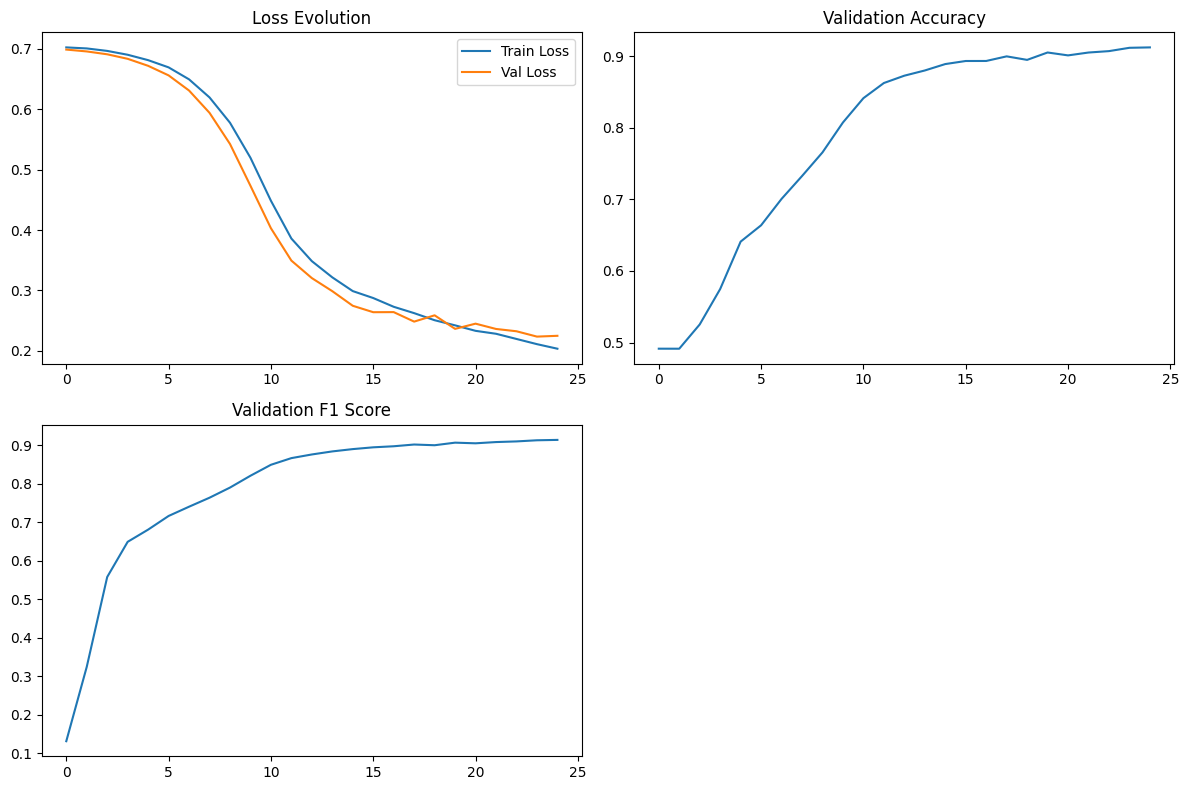

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Evolution')
plt.subplot(2, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Validation Accuracy')
plt.subplot(2, 2, 3)
plt.plot(f1_scores, label='F1 Score')
plt.title('Validation F1 Score')
plt.tight_layout()
plt.show()

### Выводы
- Точность модели достигла 91.4%. Однако, начиная с 18-й эпохи, наблюдаются признаки переобучения.
- В процессе обучения были использованы различные техники, такие как накопление градиента, регуляризация, warmup, weight decay, а также планировщик скорости обучения.
- Поскольку модель требовательна к вычислительным ресурсам, подбор гиперпараметров для её обучения оказался сложной задачей.